In [1]:
using LinearAlgebra
using Test
import Base.*, Base.\, Base.setindex!, Base.getindex, Base.size, Base.firstindex, Base.lastindex

In [2]:
"""
    RazprsenaMatrika{T}(I, V, n, m)

Razpršena matrika M, kjer so shranjeni samo neničelni elementi.
I - n x k matrika indeksov
V - n x k matrika vrednosti
n - število vrstic
m - število stolpcev
kjer je k maksimalno število neničelnih elementov v eni vrstici.
Matrika I v vrsticah hrani indekse stolpcev neničelnih elemnetov istoležne vrstice v matriki M.
Matrika V v vrsticah hrani vrednosti neničenih elementov istoležne vrstice v matriki M.
Velja V(i, j) = M(i, I(i, j))

Primer:
I = [4 1; 0 0; 1 3; 4 0; 6 0]
V = [1.0 12; 0 0; 3 4; 2 0; 8 0]
A = RazprsenaMatrika(I, V, 5, 6)

5×6 RazprsenaMatrika{Float64}:
 12.0  0  0    1.0  0  0
  0    0  0    0    0  0
  3.0  0  4.0  0    0  0
  0    0  0    2.0  0  0
  0    0  0    0    0  8.0
"""
mutable struct RazprsenaMatrika{T} <: AbstractArray{T, 2}
    I::Matrix{Int}
    V::Matrix{T}
    n::Int
    m::Int
end

RazprsenaMatrika

In [3]:
"""
    size(M)

Vrne dimenzije matrike M
"""
function size(M::RazprsenaMatrika)
    return (M.n, M.m)
end

"""
    getindex(M, I(2))

Vrne element na mestu I
"""
function getindex(M::RazprsenaMatrika, I::Vararg{Int, 2})
    j = findfirst(isequal(I[2]), M.I[I[1], :])
    if j == nothing
        return 0 
    end
    return M.V[I[1], j]
end

"""
    setindex!(M, v, I(2))

Nastavimo vrednost elementa na mestu I na vrednost v
"""
function setindex!(M::RazprsenaMatrika, v, I::Vararg{Int, 2})
    i = I[1]
    j = findfirst(isequal(I[2]), M.I[i, :])
    
    if v == 0 && j == nothing
        return
    elseif v == 0
        # spraznimo index
        M.I[i, j:end-1] = M.I[i, j+1:end]
        M.I[i, end] = 0
        M.V[i, j:end-1] = M.V[i, j+1:end]
        M.V[i, end] = 0
        return
    elseif j == nothing
        # add index
        # check if space
        jx = findfirst(isequal(0), M.I[i, :])
        if jx == nothing
            # ni plac --> add col
            ri = zeros(M.n)
            ri[i] = I[2]
            M.I = hcat(M.I, ri)
            rv = zeros(M.n)
            rv[i] = v
            M.V = hcat(M.V, rv)
        else
            # je plac
            M.I[i, jx] = I[2]
            M.V[i, jx] = v
        end
    else
        M.V[i, j] = v
    end
end

"""
    firstindex(M)

Vrne indeks prvega elementa matriki M
"""
function firstindex(M::RazprsenaMatrika)
    return 1    
end

"""
    firstindex(M, d)

Vrne indeks prvega elementa v vrstici d matrike M
"""
function firstindex(M::RazprsenaMatrika, d)
    return 1
end

"""
    lastindex(M)

Vrne indeks zadnjega elementa v matriki M
"""
function lastindex(M::RazprsenaMatrika)
    return M.n*M.m
end

"""
    lastindex(M, d)

Vrne indeks zadnjega elementa v vrstici d matrike M
"""
function lastindex(M::RazprsenaMatrika, d)
    return M.m
end

Base.lastindex

In [4]:
"""
    M*v 

Zmnoži razpršeno matriko M z vektorjem v
"""
function *(M::RazprsenaMatrika, v::Vector)
    x = zeros(M.n)
    for i=1:M.n
        ids = M.I[i, :].>0
        idsI = M.I[i, ids]
        x[i] = dot(M.V[i, ids], v[idsI])
    end
    return x
end

Base.:*

In [22]:
function matrika(M::Matrix)
    n, m = size(M)
    A = RazprsenaMatrika(zeros(Int,n, 1), zeros(n, 1), n, m)
    for i=1:n
        for j=1:m
            if M[i, j] != 0
            #     display(i)
            #     display(j)
            #     display(M[i, j])
                A[i, j] = M[i, j]
            end
        end
    end
    return A
end

matrika (generic function with 1 method)

In [66]:
"""
    conj_grad(M, b, eps, maxitr)

Izračuna rešitev sistema M*x = b z uporabo metode konjugiranih gradientov, kjer je M razpršena matrika.
Optional: nastavi se lahko prekinitveni pogoj eps in maksimalno število iteracij maxitr

Primer:
x, k = conj_grad(M, b), kjer je x rešitev sistema in k število iteracij
"""
function conj_grad(M::RazprsenaMatrika, b::Vector, eps=1e-8)

    x = zeros(M.m)
    r = b - M*x
    dotr = dot(r, r) # old r dot product
    if dotr < eps
        return (x, 0)
    end
    p = r
    k = 1
    while k<=length(b) 
        mp = M * p
        alpha = dotr / dot(p, mp)
        x += alpha * p
        r -= alpha * mp
        dotr_new = dot(r, r)
        if sqrt(dotr_new) < eps
            break
        end
        beta = dotr_new / dotr
        p = r + beta * p
        k += 1
        dotr = dotr_new # update
    end
    if norm(A*x - b, Inf) > eps
        @warn "Matrika naj bo simetrična pozitivno definitna"
    end
    return (x, k)
end


conj_grad

In [67]:
I = [4 1; 2 0; 1 3; 4 0; 5 0]
V = [1.0 12; 2 0; 3 4; 2 0; 8 0]
B = RazprsenaMatrika(I, V, 5, 5)
A = matrika(B'*B)
display(A)
display(B)
v = [1, 2, 3, 4, 5]
x, k = conj_grad(A, v)
display(k)
A*x

5×5 RazprsenaMatrika{Float64}:
 153.0  0    12.0  12.0   0
   0    4.0   0     0     0
  12.0  0    16.0   0     0
  12.0  0     0     5.0   0
   0    0     0     0    64.0

5×5 RazprsenaMatrika{Float64}:
 12.0  0    0    1.0  0
  0    2.0  0    0    0
  3.0  0    4.0  0    0
  0    0    0    2.0  0
  0    0    0    0    8.0

5

5-element Vector{Float64}:
 1.0000000000014522
 1.9999999999999998
 3.0000000000001257
 4.0000000000001155
 4.999999999999789

In [68]:
@testset "razpsena" begin
    eps = 1e-6

    I = [4 1; 0 0; 1 3; 4 0; 6 0]
    V = [1.0 12; 0 0; 3 4; 2 0; 8 0]
    A = RazprsenaMatrika(I, V, 5, 6)
    M = copy(A)
    @test norm(A-M, Inf) < eps

    @test size(M) == size(A)
    for a = [1, 2], b = [1, 3]
        val = a+b
        A[a, b] = val
        @test A[a, b] == val
    end

    M = copy(A)
    v = [1.0, 2, 3, 4, 5, 6]
    @test norm(M*v - A*v, Inf) < eps

    I = [4 1; 2 0; 1 3; 4 0; 5 0]
    V = [1.0 12; 2 0; 3 4; 2 0; 8 0]
    A = RazprsenaMatrika(I, V, 5, 5)
    A = matrika(A'*A) # make spd matrix
    v = [1.0, 2, 3, 4, 5]
    x, k = conj_grad(A, v)
    @test norm(A*x - v, Inf) < eps
end

Test Summary: | Pass  Total
razpsena      |    8      8


Test.DefaultTestSet("razpsena", Any[], 8, false, false)

In [21]:
import SparseArrays.sparse

In [22]:
s = sparse(B)

5×5 SparseArrays.SparseMatrixCSC{Float64, Int64} with 4 stored entries:
  ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
 3.0   ⋅   4.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 

In [23]:
s[1, 1]

0.0

In [87]:
# example
A = [-3 1 1 1; 1 -1 0 0; 1 0 -2 1; 1 0 1 -2]
A = matrika(A)

4×4 RazprsenaMatrika{Float64}:
 -3.0   1.0   1.0   1.0
  1.0  -1.0   0     0
  1.0   0    -2.0   1.0
  1.0   0     1.0  -2.0

In [88]:
using Plots

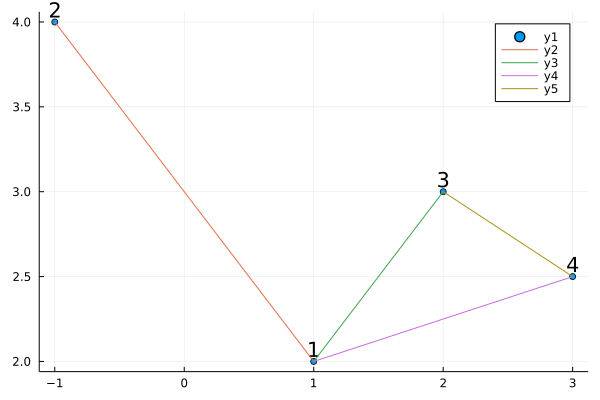

In [89]:
cord = [1 2; -1 4; 2 3; 3 2.5]
scatter(cord[:, 1], cord[:, 2], series_annotations = text.(1:length(cord), :bottom))
for i=1:A.n
    for j=1:A.m
        if A[i, j] > 0 && i < j
            plot!(cord[[i, j], 1], cord[[i, j], 2])
        end
    end
end
display(plot!())

In [139]:
fixed = [2, 3]
notfixed = collect(1:A.n)
deleteat!(notfixed, fixed)
Af = zeros(A.n-length(fixed), A.n-length(fixed))
cf = zeros(A.n, 2)
cf[fixed, :] = cord[fixed, :]
display(cf)
zx = -(A * cf[:, 1])#[notfixed]
zy = -(A * cf[:, 2])#[notfixed]
display(zx)
# j = 1
# for i=1:A.n
#     if i ∉ fixed
#         Af[j, :] = copy(A[i, notfixed])
#         j += 1
#     end
# end
Af = matrika(copy(A))#[:, notfixed]))
Af[:, fixed] = zeros(A.n, length(fixed))
# Af = matrika(Af)
Af

4×2 Matrix{Float64}:
  0.0  0.0
 -1.0  4.0
  2.0  3.0
  0.0  0.0

4-element Vector{Float64}:
 -1.0
 -1.0
  4.0
 -2.0

4×4 RazprsenaMatrika{Float64}:
 -3.0  0  0   1.0
  1.0  0  0   0
  1.0  0  0   1.0
  1.0  0  0  -2.0

In [141]:
x, ix = conj_grad(Af, zx, 1e-6, 300)
y, iy = conj_grad(Af, zy, 1e-6, 300)
display(ix)
display(x)
display(iy)
display(y)

301

4-element Vector{Float64}:
 200295.69388371654
     -7.964077268753404e6
      5.1208751793586975e6
      2.6283056772727035e6

301

4-element Vector{Float64}:
 -1.021878272988419e17
  3.5242352419573596e18
 -2.2592764340622387e18
 -1.1627709805962775e18

In [144]:
# cf[notfixed, 1] = x
# cf[notfixed, 2] = y
cf

4×2 Matrix{Float64}:
  0.0  0.0
 -1.0  4.0
  2.0  3.0
  0.0  0.0

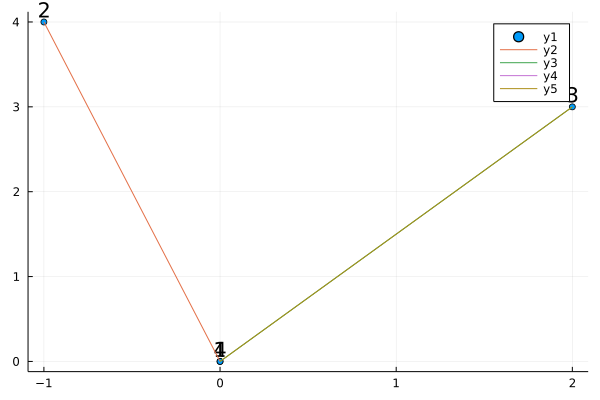

In [143]:
ncord = deepcopy(cf)
scatter(ncord[:, 1], ncord[:, 2], series_annotations = text.(1:length(ncord), :bottom))
for i=1:A.n
    for j=1:A.m
        if A[i, j] > 0 && i < j
            plot!(ncord[[i, j], 1], ncord[[i, j], 2])
        end
    end
end
display(plot!())